# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## План проекта

    1 Подготовка данных
        - Осмотр и загрузка данных
        - Удаление неинформативных признаков
        - Обработка пропусков
        - Обработка редких значений
        - Обработка категориальных признаков
        - Создание новых признаков
        - Обработка количественных признаков
        - Разбиение на трейн и тест
    2 Исследование задачи
        - Анализ баланса классов
        - Тестирование моделей без устранения дизбаланса
    3 Борьба с дисбалансом
        - Отбрасывание избыточных образцов
        - Дублирование недостающих образцов
        - Учет дизбаланса на уровне весов
        - Оптимизация гиперпараметров модели
        - ROC-AUC curve
    4 Тестирование модели

## Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, recall_score, make_scorer, classification_report
%matplotlib inline

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, PredefinedSplit

In [4]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import shuffle

In [5]:
from sklearn.metrics import roc_curve 

In [6]:
import numpy as np

In [7]:
import warnings
warnings.filterwarnings('ignore', '.*')

## Подготовка данных

### Осмотр данных

Осматриваем данные на предмет того, нужно ли что-то учесть при загрузке

In [8]:
!head ./datasets/Churn.csv

Похоже, первая колонка - индекс, разделитель и десятичные знаки стандартные, дат нет

In [9]:
df = pd.read_csv('./datasets/Churn.csv', index_col=0)

In [10]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


In [12]:
df.nunique()

CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

### Удаление неинформативных признаков

Колонка CustomerId носит описательный характер,т.е. это уникальный идентификатор пользователя, который признаком не являются. Отбросим ее - полезной информации в них нет. Фамилия могла бы быть полезным признаком (общее поведение у родственников), если бы была более точная география или отчество, а без этого она может скорее дизориентировать модель, потому безопаснее ее исключить.

In [13]:
df = df.drop(['CustomerId', 'Surname'], axis=1)

### Обработка пропусков

Пропуски есть только в колонке Tenure, причем их порядка 10%, то есть просто отбрасывать эту часть данных некорректно. Можно допустить, что это люди, которые стали клиентами банка недавно, и заполнить пропуски нулями

In [14]:
df['Tenure'] = df.Tenure.fillna(0)

### Анализ редких значений

#### Категориальные признаки

In [15]:
categorials = ['HasCrCard', 'IsActiveMember', 'Gender', 'Geography']

In [16]:
for col in categorials:
    print(df[col].value_counts(normalize=True))

1    0.7055
0    0.2945
Name: HasCrCard, dtype: float64
1    0.5151
0    0.4849
Name: IsActiveMember, dtype: float64
Male      0.5457
Female    0.4543
Name: Gender, dtype: float64
France     0.5014
Germany    0.2509
Spain      0.2477
Name: Geography, dtype: float64


Частоты категориальных признаков составляют не менее 25%, то есть редких значений нет

#### Количественные признаки

In [17]:
pd.options.display.float_format = '{:.2f}'.format

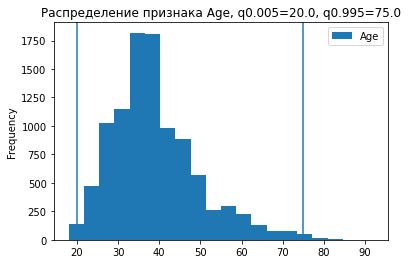

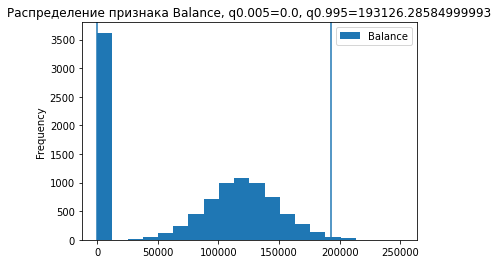

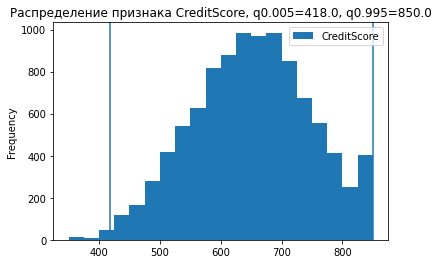

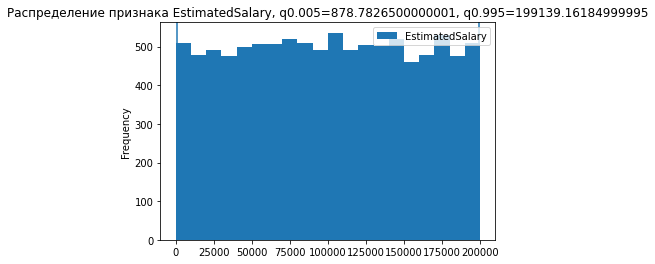

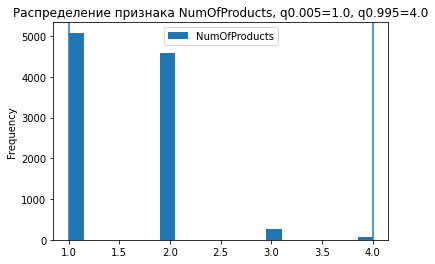

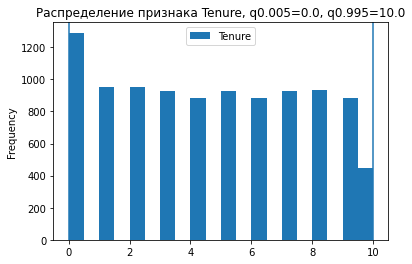

In [18]:
# Исходный вид данных
for col in df.columns.difference(categorials+['Exited']):
    df[[col]].plot(kind='hist', bins=20);
    plt.title(f'Распределение признака {col}, '+
              f'q0.005={df[[col]].quantile(q=0.005)[0]}, '+
              f'q0.995={df[[col]].quantile(q=0.995)[0]}');
    plt.axvline(df[[col]].quantile(q=0.995)[0])
    plt.axvline(df[[col]].quantile(q=0.005)[0])

In [19]:
df.drop(categorials+['Exited'], axis=1).describe(
    percentiles=[0.005,0.01, 0.05, 0.95, 0.975, 0.99,0.995])

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,650.53,38.92,4.54,76485.89,1.53,100090.24
std,96.65,10.49,3.11,62397.41,0.58,57510.49
min,350.00,18.00,0.00,0.00,1.00,11.58
0.5%,418.00,20.00,0.00,0.00,1.00,878.78
1%,432.00,21.00,0.00,0.00,1.00,1842.83
5%,489.00,25.00,0.00,0.00,1.00,9851.82
50%,652.00,37.00,4.00,97198.54,1.00,100193.91
95%,812.00,60.00,9.00,162711.67,2.00,190155.38
97.5%,847.00,66.00,10.00,174180.53,3.00,195168.01


Можно удалить редкие значения:
- для CreditScore малые значения ниже 432
- для Age значения меньше 20 лет и больше 75 лет
- для баланса значения больше 193126
- для NumOfProducts больше 3

In [20]:
df = df[df.CreditScore >= 432]
df = df[df.Balance <= 193126]
df = df[df.NumOfProducts <= 3]
df = df[(df.Age >= 20)&(df.Age<=75)]

In [21]:
(10000 - df.shape[0])/10000*100

3.0

Исключено порядка 3% данных, что приемлемо

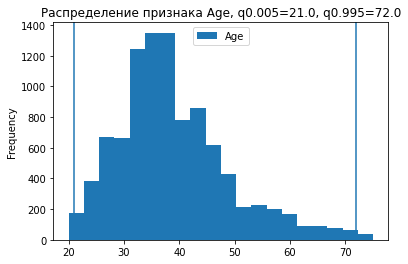

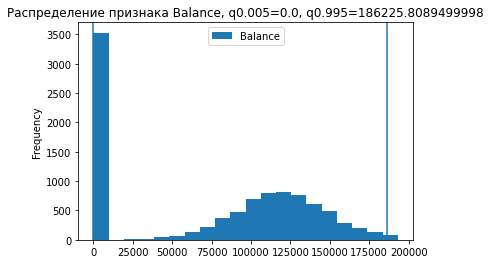

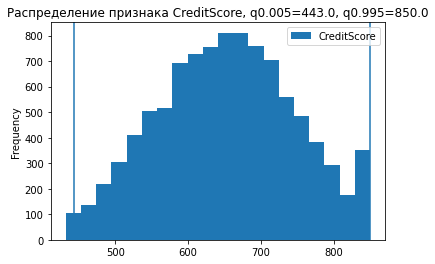

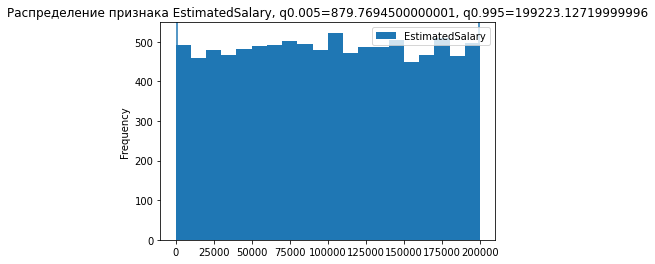

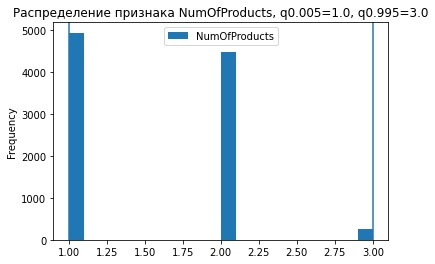

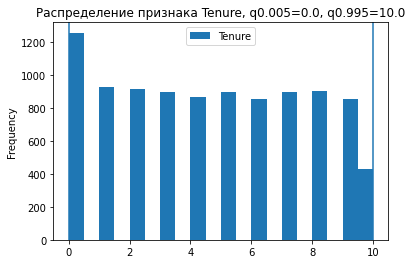

In [22]:
# Вид данных после фильтрации
for col in df.columns.difference(categorials+['Exited']):
    df[[col]].plot(kind='hist', bins=20);
    plt.title(f'Распределение признака {col}, '+
              f'q0.005={df[[col]].quantile(q=0.005)[0]}, '+
              f'q0.995={df[[col]].quantile(q=0.995)[0]}');
    plt.axvline(df[[col]].quantile(q=0.995)[0])
    plt.axvline(df[[col]].quantile(q=0.005)[0])

Наблюдается аномалия в признаке Balance: очень много нулей при условии, что в целом данные распределены нормально. Возможно, это сбой выгрузки данных либо счета клиентов, которые уже покинули банк. Проверим вторую гипотезу

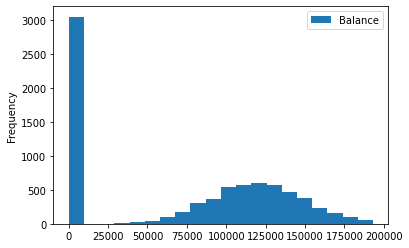

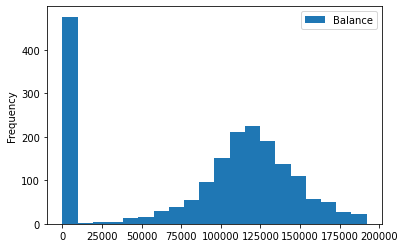

In [23]:
df.groupby('Exited')[['Balance']].plot(kind='hist', bins=20);

Доля нулей велика и у оставшихся клиентов, и у ушедших. Попробуем проверить, с какими колонками коррелирует balance

In [24]:
df[df.Balance>0].corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.00,-0.01,-0.00,-0.00,0.01,-0.01,0.03,0.01,-0.02
Age,-0.01,1.00,0.01,-0.01,-0.01,-0.02,0.06,-0.01,0.32
Tenure,-0.00,0.01,1.00,0.00,-0.00,0.02,-0.04,0.01,-0.01
Balance,-0.00,-0.01,0.00,1.00,-0.00,0.01,-0.02,-0.01,0.00
NumOfProducts,0.01,-0.01,-0.00,-0.00,1.00,0.00,-0.00,0.03,0.02
HasCrCard,-0.01,-0.02,0.02,0.01,0.00,1.00,-0.02,-0.01,-0.00
IsActiveMember,0.03,0.06,-0.04,-0.02,-0.00,-0.02,1.00,-0.01,-0.17
EstimatedSalary,0.01,-0.01,0.01,-0.01,0.03,-0.01,-0.01,1.00,0.00
Exited,-0.02,0.32,-0.01,0.00,0.02,-0.00,-0.17,0.00,1.00


Значимых корреляций нет. Заполним медианным значением по выборке

In [25]:
df.loc[df.Balance==0, 'Balance'] = df[df.Balance>0]['Balance'].median()

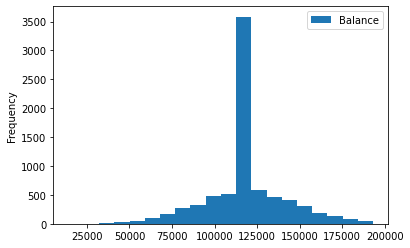

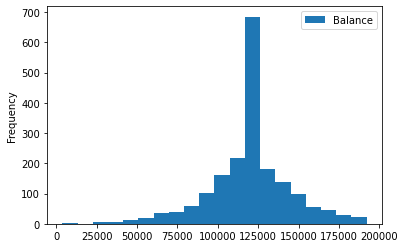

In [26]:
df.groupby('Exited')[['Balance']].plot(kind='hist', bins=20);

In [27]:
df.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.00,-0.00,0.00,-0.00,0.01,-0.00,0.02,-0.00,-0.02
Age,-0.00,1.00,-0.01,-0.01,-0.05,-0.01,0.08,-0.01,0.30
Tenure,0.00,-0.01,1.00,0.00,0.01,0.02,-0.03,0.01,-0.01
Balance,-0.00,-0.01,0.00,1.00,-0.00,0.01,-0.02,-0.00,0.00
NumOfProducts,0.01,-0.05,0.01,-0.00,1.00,0.00,0.01,0.01,-0.10
HasCrCard,-0.00,-0.01,0.02,0.01,0.00,1.00,-0.01,-0.01,-0.01
IsActiveMember,0.02,0.08,-0.03,-0.02,0.01,-0.01,1.00,-0.01,-0.16
EstimatedSalary,-0.00,-0.01,0.01,-0.00,0.01,-0.01,-0.01,1.00,0.01
Exited,-0.02,0.30,-0.01,0.00,-0.10,-0.01,-0.16,0.01,1.00


Новых корреляций привнесено не было, распределение в целевых классах не изменилось, будем считать замену корректной

### Обработка категориальных признаков

Признаки пол и страна проживания - категориальные признаки. Пол можно кодировать простым сравнением с Female, а страну преобразовать в дамми-переменные с отбрасыванием первой избыточной переменной

In [28]:
df['Gender'] = (df.Gender == 'Female').astype(int)

In [29]:
df = pd.get_dummies(df, drop_first=True)

### Feature Engineering

Признаки Balance, EstimatedSalary, CreditScore и Age выглядят чересчур многообразными для задачи классификации. Разобьем их на категории по квартилям

In [30]:
df['balance_cat'] = pd.qcut(df['Balance'],4, duplicates='drop', labels=range(4))
df['salary_cat'] = pd.qcut(df['EstimatedSalary'],4, duplicates='drop', labels=range(4))
df['score_cat'] = pd.qcut(df['CreditScore'],4, duplicates='drop', labels=range(4))
df['age_cat'] = pd.qcut(df['Age'],4, duplicates='drop', labels=range(4))
age_cat = df['age_cat'] # сохраним на будущее

### Обработка количественных признаков

In [31]:
# количественные признаки
quants = df.columns.difference(categorials+['Exited'])

Будем использовать MinMaxScaler, чтобы в итоге все признаки попали в диапазон [0..1]

### Разбиение на трейн и тест

In [32]:
# оставим 15% данных для итогового тестирования
# поскольку задача предполагает сравнение разных методов борьбы с дисбалансом, 
#    отрежем еще 15% для валидации
# оптимизацию будем делать с помощью кросс-валидации
# При разбиении будем использовать 


target = df['Exited']
features = df.drop(['Exited'] , axis=1)
features_train, features_test, target_train, target_test, cat_train, cat_test = train_test_split(
    features, target, age_cat, test_size=0.15, random_state=42, stratify=age_cat)

Для того, чтобы в дальнейшем использовать автоматизированный перебор гиперпараметров, выделим валидационную выборку с помощью PrediefinedSplit

In [33]:
_, _, _, target_valid = train_test_split(
    features_train, target_train, test_size=len(target_test), random_state=42, 
    stratify=cat_train)

In [34]:
valid_fold = target_train.index.isin(target_valid.index)

In [35]:
marked_valid_fold = valid_fold.copy().astype(int)
marked_valid_fold[marked_valid_fold==0] = -1
ps = PredefinedSplit(test_fold=marked_valid_fold)

### Масштабирование

Будем использовать MinMaxScaler, чтобы в итоге все признаки попали в диапазон [0..1]

In [36]:
scl = MinMaxScaler()

In [37]:
scl.fit(features_train[quants][~valid_fold])
features_train.loc[:,quants] = scl.transform(features_train[quants])
features_test.loc[:,quants] = scl.transform(features_test[quants])

**Итог**

    - Датасет содержит 10000 образцов    
    - Пропуски есть только в колонке Tenure, причем их порядка 10%, то есть просто отбрасывать эту часть данных некорректно. Можно допустить, что это люди, которые стали клиентами банка недавно, и заполнить пропуски нулями
    - удалены признаки Surname и CustomerId как неинформативные
    - Проведена фильтрация редких значений
        - Частоты категориальных признаков составляют не менее 25%, то есть редких значений нет
        - для CreditScore малые значения ниже 432
        - для Age значения меньше 20 лет и больше 75 лет
        - для баланса значения больше 193126
        - для NumOfProducts больше 3
    - Наблюдается аномалия в признаке Balance: очень много нулей при условии, что в целом данные распределены нормально. Нули одинаково представлены для обоих целевых классов, значение признака не коррелирует с другими признаками; нули заменены медианным значением признака.
    - Пол кодирован простым сравнением с Female
    - Страна преобразована в дамми-переменные с отбрасыванием первой избыточной переменной
    - Признаки Balance, EstimatedSalary, CreditScore и Age выглядели чересчур многообразными для задачи классификации. Для преодоления их разбили на категории по квартилям
    - Количественные признаки нормированы MinMaxScaler, чтобы в итоге все признаки попали в диапазон [0..1]    

## Исследование задачи

### Анализ баланса классов

In [38]:
target_train.value_counts(normalize=True)

0   0.80
1   0.20
Name: Exited, dtype: float64

Наблюдается выраженный дисбаланс классов

### Модели без устранения дизбаланса

In [39]:
for model in \
    ['ExtraTreesClassifier', 'RandomForestClassifier', 'LogisticRegression']:
    if model == 'SVC':        
        clf = eval(model)(random_state=42, probability=True)
    else:
        clf = eval(model)(random_state=42)
    clf.fit(features_train[~valid_fold], target_train[~valid_fold])
    preds_val = clf.predict(features_train[valid_fold])
    proba_val = clf.predict_proba(features_train[valid_fold])[:,1]

    print(f'Model {model} AUC={roc_auc_score(target_train[valid_fold], proba_val):.3f}'+
         f' f1={f1_score(target_train[valid_fold], preds_val):.3f}'+
         f' recall={recall_score(target_train[valid_fold], preds_val):.3f}')
    print()

Model ExtraTreesClassifier AUC=0.845 f1=0.539 recall=0.429

Model RandomForestClassifier AUC=0.845 f1=0.559 recall=0.439

Model LogisticRegression AUC=0.782 f1=0.394 recall=0.272



Видно, что для логистической регрессии Recall на редком целевом классе низкий, то есть нужно компенсировать дисбаланс классов

Наилучшие результаты показывает RandomForestClassifier, его и будем оптимизировать

## Борьба с дисбалансом

### Отбрасывание избыточных образцов

In [40]:
# пробуем отбросить образцы отрицательного класса

ftr_pos = features_train[~valid_fold][target_train[~valid_fold]==1]
tgt_pos = target_train[~valid_fold][target_train[~valid_fold]==1]
tgt_neg = target_train[~valid_fold][target_train[~valid_fold]==0].sample(len(tgt_pos))
ftr_neg = features_train[~valid_fold][target_train[~valid_fold]==0].sample(len(tgt_pos))

features_train_trunc,target_train_trunc = shuffle(pd.concat([ftr_pos]+[ftr_neg]), 
                               pd.concat([tgt_pos]+[tgt_neg]), 
                                                 random_state=42)

target_train_trunc.value_counts(normalize=True)

1   0.50
0   0.50
Name: Exited, dtype: float64

In [41]:
clf_trunc = RandomForestClassifier(random_state=42)
clf_trunc.fit(features_train_trunc, target_train_trunc)
preds_valid = clf_trunc.predict(features_train[valid_fold])
prob_val = clf_trunc.predict_proba(features_train[valid_fold])[:,1]

print(f'Model RandomForestClassifier AUC={roc_auc_score(target_train[valid_fold], prob_val):.3f}'+
     f' f1={f1_score(target_train[valid_fold], preds_valid):.3f}'+
     f' recall={recall_score(target_train[valid_fold], preds_valid):.3f}')

Model RandomForestClassifier AUC=0.846 f1=0.584 recall=0.742


### Дублирование недостающих образцов

In [42]:
# пробуем дублировать образцы положительного класса

features_train_dup,target_train_dup = shuffle(
    pd.concat([features_train[~valid_fold][target_train[~valid_fold]==1]]*4
              +[features_train[~valid_fold][target_train[~valid_fold]==0]]), 
    pd.concat([target_train[~valid_fold][target_train[~valid_fold]==1]]*4
              +[target_train[~valid_fold][target_train[~valid_fold]==0]]), 
    random_state=42)

target_train_dup.value_counts(normalize=True)

0   0.50
1   0.50
Name: Exited, dtype: float64

In [43]:
clf_dup = RandomForestClassifier(random_state=42)
clf_dup.fit(features_train_trunc, target_train_trunc)
preds_valid = clf_dup.predict(features_train[valid_fold])
prob_val = clf_dup.predict_proba(features_train[valid_fold])[:,1]

print(f'Model RandomForestClassifier AUC={roc_auc_score(target_train[valid_fold], prob_val):.3f}'+
     f' f1={f1_score(target_train[valid_fold], preds_valid):.3f}'+
     f' recall={recall_score(target_train[valid_fold], preds_valid):.3f}')

Model RandomForestClassifier AUC=0.846 f1=0.584 recall=0.742


### Учет дизбаланса на уровне модели

Метрика получается хорошая, но проведем дополнительно оптимизацию модели с учетом дисбаланса классов

In [44]:
# пробуем учесть баланс классов на уровне модели
clf = RandomForestClassifier(random_state=42, class_weight="balanced")
clf.fit(features_train[~valid_fold], target_train[~valid_fold])
preds_valid = clf.predict(features_train[valid_fold])
prob_val = clf.predict_proba(features_train[valid_fold])[:,1]

print(f'Model RandomForestClassifier AUC={roc_auc_score(target_train[valid_fold], prob_val):.3f}'+
     f' f1={f1_score(target_train[valid_fold], preds_valid):.3f}'+
     f' recall={recall_score(target_train[valid_fold], preds_valid):.3f}')

Model RandomForestClassifier AUC=0.848 f1=0.531 recall=0.401


### Оптимизация гиперпараметров модели

In [45]:
params = dict(
    n_estimators=range(10,500,10),
    max_depth=range(1,50,1),
    max_features=range(1,features_train.shape[1],1)
)

In [46]:
clf = RandomForestClassifier(random_state=42,class_weight="balanced")
opt = RandomizedSearchCV(clf, params, n_iter=100, verbose=1,
                         scoring=make_scorer(f1_score), cv=ps, random_state=42)
opt.fit(features_train, 
        target_train)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1,  1])),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': range(1, 50),
                                        'max_features': range(1, 15),
                                        'n_estimators': range(10, 500, 10)},
                   random_state=42, scoring=make_scorer(f1_score), verbose=1)

In [47]:
opt.best_params_

{'n_estimators': 410, 'max_features': 4, 'max_depth': 9}

In [48]:
opt.best_score_

0.6188034188034188

### ROC-AUC curve

Попробуем оптимизировать threshold для отнесения объектов к позитивному классу

In [49]:
# расчеты для кривой ROC
probabilities_valid= opt.predict_proba(features_train[valid_fold])[:,1]
fpr, tpr, thresholds = roc_curve(target_train[valid_fold], probabilities_valid)

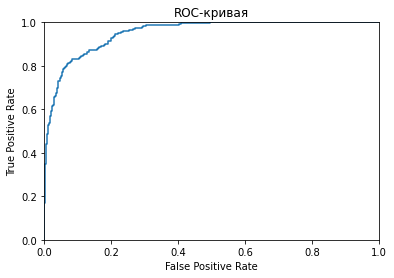

In [50]:
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

Видно, что в районе TPR 0.8 происходит резкое падение скорости ее роста и ускорение прироста FPR. Поищем оптимальный threshold в этом районе

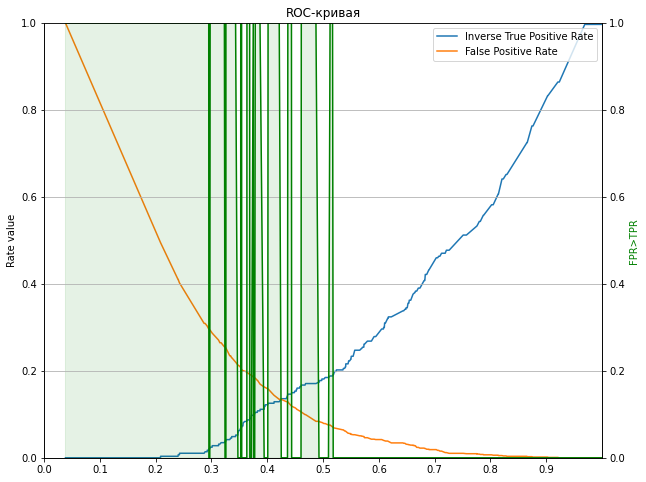

In [51]:
fig, ax1 = plt.subplots(figsize=(10,8))
ax2 = ax1.twinx()
ax1.plot(thresholds, 1-tpr, label='Inverse True Positive Rate')
ax1.plot(thresholds, fpr, label='False Positive Rate')
ax2.plot(thresholds, (np.gradient(tpr)<np.gradient(fpr)), 
         label='Изменение FPR > TPR', color='green')
ax2.fill_between(thresholds, (np.gradient(tpr)<np.gradient(fpr)), alpha=0.1, color='green')
plt.xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
plt.xticks(np.arange(0,1,0.1))
plt.xlabel('Threshold')
ax1.set_ylabel('Rate value')
ax2.set_ylabel("FPR>TPR", color='green')
plt.title('ROC-кривая')
plt.grid()
ax1.legend(loc='upper right')
plt.show() 

Получается, что после threshold ~0.45 скорость снижения FPR меньше скорости снижения TPR, можно принять это как рабочий threshold

## Тестирование модели

In [52]:
preds_test = opt.predict_proba(features_test)[:,1]>=0.45
proba_test = opt.predict_proba(features_test)[:,1]
print(f'Model RandomForestClassifier with model balance AUC={roc_auc_score(target_test, proba_test):.3f}'+
         f' f1={f1_score(target_test, preds_test):.3f}')
print(classification_report(target_test, preds_test))

Model RandomForestClassifier with model balance AUC=0.846 f1=0.598
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1166
           1       0.53      0.68      0.60       289

    accuracy                           0.82      1455
   macro avg       0.72      0.77      0.74      1455
weighted avg       0.84      0.82      0.83      1455



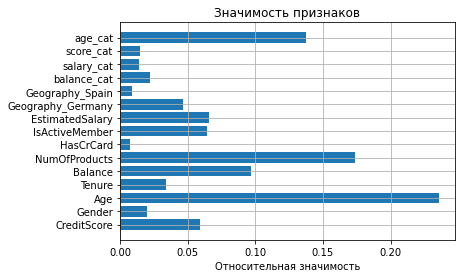

In [53]:
plt.barh(features_train.columns, opt.best_estimator_.feature_importances_)
plt.title('Значимость признаков')
plt.xlabel('Относительная значимость')
plt.grid()
plt.show()

## Выводы

Цель проекта - спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Признаки

    RowNumber — индекс строки в данных
    CustomerId — уникальный идентификатор клиента
    Surname — фамилия
    CreditScore — кредитный рейтинг
    Geography — страна проживания
    Gender — пол
    Age — возраст
    Tenure — сколько лет человек является клиентом банка
    Balance — баланс на счёте
    NumOfProducts — количество продуктов банка, используемых клиентом
    HasCrCard — наличие кредитной карты
    IsActiveMember — активность клиента
    EstimatedSalary — предполагаемая зарплата

Целевой признак

    Exited — факт ухода клиента

Подготовка данных

    - Датасет содержит 10000 образцов    
    - Пропуски есть только в колонке Tenure, причем их порядка 10%, то есть просто отбрасывать эту часть данных некорректно. Можно допустить, что это люди, которые стали клиентами банка недавно, и заполнить пропуски нулями
    - удалены признаки Surname и CustomerId как неинформативные
    - Проведена фильтрация редких значений
        - Частоты категориальных признаков составляют не менее 25%, то есть редких значений нет
        - для CreditScore малые значения ниже 432
        - для Age значения меньше 20 лет и больше 75 лет
        - для баланса значения больше 193126
        - для NumOfProducts больше 3
    - Наблюдается аномалия в признаке Balance: очень много нулей при условии, что в целом данные распределены нормально. Нули одинаково представлены для обоих целевых классов, значение признака не коррелирует с другими признаками; нули заменены медианным значением признака.
    - Пол кодирован простым сравнением с Female
    - Страна преобразована в дамми-переменные с отбрасыванием первой избыточной переменной
    - Признаки Balance, EstimatedSalary, CreditScore и Age выглядели чересчур многообразными для задачи классификации. Для преодоления их разбили на категории по квартилям
    - Количественные признаки нормированы MinMaxScaler, чтобы в итоге все признаки попали в диапазон [0..1]  
    - данные разбиты в пропорциях 70:15:15 на трейн, валидацию и тест с стратификацией по возрастам, поскольку данный признак сильно коррелирует с целевым

Исследование задачи

    - Наблюдается выраженный дисбаланс классов
    - для SVC и логистической регрессии Recall на редком целевом классе низкий, то есть нужно компенсировать дисбаланс классов
    - Наилучшие результаты показывает RandomForestClassifier с f1=0.53, его и будем оптимизировать
    
Борьба с дизбалансом

    - Проверены методы устранения дисбаланса
        - Отбрасывание образцов так, чтобы доли классов сравнялись (т.е. порядка 3/5 всех данных)
        - Добавление дублированных редких образцов (по 3 дополнительные копии каждого)
        - учет дизбаланса с помощью параметра class_weight модели
    - Все методы дали примерно одинаковый результат f1~=0.571
    - Для варианта с class weight проведена оптимизация гиперпараметров как для подхода, в наибольшей степени совместимого с кросс-валидацией; оптимальный набор {'n_estimators': 270, 'max_features': 5, 'max_depth': 10}; максимально достигнутая метрика f1=0.596
    - Для дополнительной оптимизации проведен анализ кривой ROC
        - В районе TPR 0.8 происходит резкое падение скорости ее роста и ускорение прироста FPR. 
        - Проведен поиск оптимального threshold в этом районе
        - После threshold ~0.42 скорость снижения FPR меньше скорости снижения TPR, и  это значение принято как рабочий threshold
        
Тестирование модели

    - Для итоговой модели на тестовой выборке получены следующие значения метрик
    
AUC=0.846 

f1=0.598

                  precision    recall  f1-score   support

               0       0.92      0.85      0.88      1166
               1       0.53      0.68      0.60       289

        accuracy                           0.82      1455
       macro avg       0.72      0.77      0.74      1455
    weighted avg       0.84      0.82      0.83      1455
    
    - Наиболее значимыми признаками оказались возраст, категория возраста, число банковских продуктов и баланс

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*